## Lab 1

### Part 2: Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [ ]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

! pip  install subword-nmt
! pip install nltk
! pip install torchtext==0.2.3
! pip install pymorphy2
! pip install -U spacy
# ! python -m spacy download en_core_web_sm
# ! python -m spacy download ru_core_news_sm
# ! pip install -U transformers
! pip install -U sentencepiece
# ! pip install -U torch

In [1]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github. Loading special files as well")
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced_s21/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github. Loading special files as well
File ‘data.txt’ already there; not retrieving.



In [3]:
if not os.path.exists('./utils.py'):
    print("utils file not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced_s21/homeworks_advanced/Lab1_NLP/utils.py -nc

if not os.path.exists('./my_network.py'):
    print("network file not found locally. Downloading from github.")
    # !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced_s21/homeworks_advanced/Lab1_NLP/my_network.py -nc
    !wget https://raw.githubusercontent.com/alexunderch/Bachelor_materials/main/ml-mipt_advanced/Fun_NLP/my_network.py -nc

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset
from torchtext.data import Field, BucketIterator
from torchsummary import summary

import spacy
from spacy.lang.ru import Russian
from spacy.lang.en import English

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
# from subword_nmt.learn_bpe import learn_bpe
# from subword_nmt.apply_bpe import BPE

from torch.optim.lr_scheduler import ReduceLROnPlateau
import sentencepiece as spm

In [18]:
import pandas as pd
data = pd.read_csv(path_do_data, sep = "\t", header = None).sample(frac = .8)
data[1].to_csv("ru.txt", sep = '\t', header = False, index = False)
data[0].to_csv("eng.txt", sep = '\t', header = False, index = False)

spm.SentencePieceTrainer.train(input = 'ru.txt', model_prefix = 'm_ru', vocab_size = 2500, model_type = 'bpe')
spm.SentencePieceTrainer.train(input = 'eng.txt', model_prefix = 'm_eng', vocab_size = 2500, model_type = 'bpe')


### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [19]:
tokenizer_W = WordPunctTokenizer()
# ru = spacy.load('ru_core_news_sm')
# en = spacy.load("en_core_web_sm")
# def tokenize_ru(x): return [token.text for token in ru(x.lower())]
# def tokenize_en(x): return [token.text for token in en(x.lower())]

def tokenize(x, tokenizer = tokenizer_W):
    return tokenizer.tokenize(x.lower())
def bpe_tokenizer_en(x):
  return spm.SentencePieceProcessor(model_file = 'm_eng.model').encode(x, out_type = str)

def bpe_tokenizer_ru(x):
  return spm.SentencePieceProcessor(model_file = 'm_ru.model').encode(x, out_type = str)

In [54]:
SRC = Field(tokenize = tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            # fix_length = 100, #if use bpe
            lower = True)

TRG = Field(tokenize = tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>',
            # fix_length = 100, #if use bpe
            lower = True)

dataset = torchtext.data.TabularDataset(
    path = path_do_data,
    format = 'tsv',
    fields = [('trg', TRG), ('src', SRC)])

In [55]:
train_data, valid_data, test_data = dataset.split(split_ratio = [0.8, 0.15, 0.05])

In [56]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [57]:
TRG.build_vocab(train_data, min_freq = 3)
SRC.build_vocab(train_data, min_freq = 3)


In [58]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9196
Unique tokens in target (en) vocabulary: 6661


Here are tokens from original (RU) corpus:

In [59]:
SRC.vocab.itos[::100]

['<unk>',
 'имеется',
 'доехать',
 'de',
 'музей',
 'автомагистрали',
 'комнатами',
 'виды',
 'хостеле',
 'располагается',
 'гранд',
 'солнечная',
 'специализируется',
 'кассы',
 'продуктового',
 'завтраков',
 'ницца',
 'удобствам',
 'тостер',
 'общим',
 'туристических',
 'балатон',
 'владельцы',
 'горной',
 'гостиную',
 'бане',
 'dar',
 'пути',
 'кемпинге',
 'художественного',
 'кондиционирования',
 'ферма',
 'ипподрома',
 'раскопок',
 'абруццо',
 'кур',
 'свободно',
 'sochi',
 'источники',
 'поляна',
 '101',
 'бодрума',
 'каток',
 'пешеходным',
 'тщательно',
 'marais',
 'велоспорта',
 'классически',
 'пагода',
 'снаряжением',
 'электрическое',
 'mutiara',
 'алматы',
 'городков',
 'каталонской',
 'милан',
 'плитки',
 'скалолазанием',
 'флик',
 'bell',
 'krone',
 'venus',
 'варенье',
 'двухместной',
 'каира',
 'лесного',
 'находящиеся',
 'пассажирский',
 'развлекательном',
 'сплава',
 'форталеза',
 'abc',
 'ciudad',
 'hauts',
 'monti',
 'serene',
 'альпийский',
 'биаррица',
 'водный',


And from target (EN) corpus:

In [60]:
TRG.vocab.itos[::100]

['<unk>',
 'dining',
 'units',
 'less',
 'selection',
 'homemade',
 'rentals',
 'communal',
 'golden',
 'cottages',
 'tranquil',
 'hydromassage',
 'bowling',
 'odessa',
 'even',
 'peter',
 'owners',
 'goa',
 'price',
 'alley',
 'condo',
 'champagne',
 '000',
 'reservoir',
 'grilled',
 'august',
 'mystic',
 'anne',
 'john',
 'technology',
 'corniche',
 'miniature',
 'topkapi',
 'combination',
 'julian',
 'pis',
 'vegetable',
 'berry',
 'divnomorskoye',
 'important',
 'mirage',
 'resto',
 'turismo',
 'americinn',
 'cacao',
 'dorm',
 'hamra',
 'laundered',
 'nevsehir',
 'reus',
 'stavros',
 'wells',
 'ambassador',
 'belexpo',
 'cats',
 'deauville',
 'filho',
 'halles',
 'kaike',
 'lorne',
 'montpellier',
 'olmedo',
 'piraeus',
 'rim',
 'silk',
 'tianyi',
 'volley']

And here is example from train dataset:

In [61]:
print(vars(train_data.examples[9]))

{'trg': ['free', 'public', 'parking', 'is', 'available', 'nearby', '.'], 'src': ['неподалеку', 'расположена', 'бесплатная', 'общественная', 'парковка', '.']}


Let's check the length distributions:

Length distribution in Train data


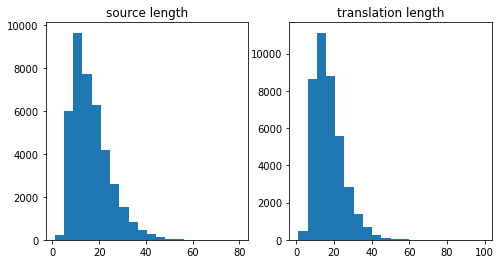

In [62]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


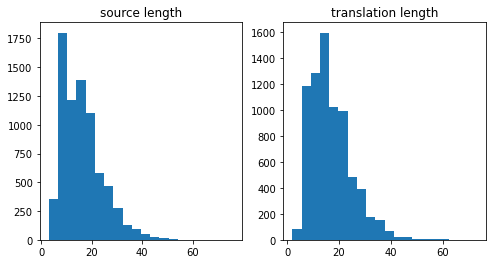

In [63]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [64]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [65]:
device

device(type='cuda')

In [66]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    repeat = False,
    sort_key = _len_sort_key)

In [67]:
for x in train_iterator:
    batch = x
print(len(train_iterator))
print(x.src.shape, x.trg.shape)

PAD_IDX = TRG.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

313
torch.Size([51, 128]) torch.Size([50, 128])


In [68]:

N_EPOCHS = 15
CLIP = 1
DIGIT = 0.08
def init_weights(m, digit = DIGIT):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -digit, digit)
        
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
 
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg, .5)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].reshape(-1, output.shape[-1])
        trg = trg[1:].reshape(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
       
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        ReduceLROnPlateau(optimizer, patience = 2, factor = 0.3).step(history[-1])
 
        if (i+1)%10 == 0:
            fig, ax =  plt.subplots(nrows = 1, ncols = 2, figsize = (12, 8))
            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()
 
        
    return epoch_loss / len(iterator)
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):
 
            src = batch.src
            trg = batch.trg
 
            output = model(src, trg, 0) #turn off teacher forcing
 
            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]
 
            output = output[1:].reshape(-1, output.shape[-1])
            trg = trg[1:].reshape(-1)
 
            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]
            # with torch.no_grad():
            #     print([TRG.vocab.itos[token] for token in output.max(1)[1].cpu().numpy()])
            loss = criterion(output, trg)
           
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)
 
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

 
def train_process(model, n_epochs = N_EPOCHS, train_iterator = train_iterator,  valid_iterator = valid_iterator,
                  criterion = criterion, clip = CLIP):
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay = 0.05, amsgrad = True)
    best_valid_loss = float('inf')
 
    for epoch in range(n_epochs):
        
        start_time = time.time()
        
        train_loss = train(model, train_iterator, optimizer, criterion, clip, train_history, valid_history)
        valid_loss = evaluate(model, valid_iterator, criterion)
        
        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'tut1-model.pt')
        
        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

from nltk.translate.bleu_score import corpus_bleu

def translate(model, test_iterator = test_iterator):
    import tqdm

    original_text = []
    generated_text = []
    _ = model.eval()
    with torch.no_grad():
        for i, batch in tqdm.tqdm(enumerate(test_iterator)):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output.argmax(dim = -1)
            
            original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
            generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])
    return original_text, generated_text

__LSTM Attention Encoder-Decoder w/ BPE__

In [48]:
import imp

import my_network
imp.reload(my_network)
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

train_history = []
valid_history = []


INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
HID_DIM = 256
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model_attn = Seq2Seq(enc, dec, device).to(device)

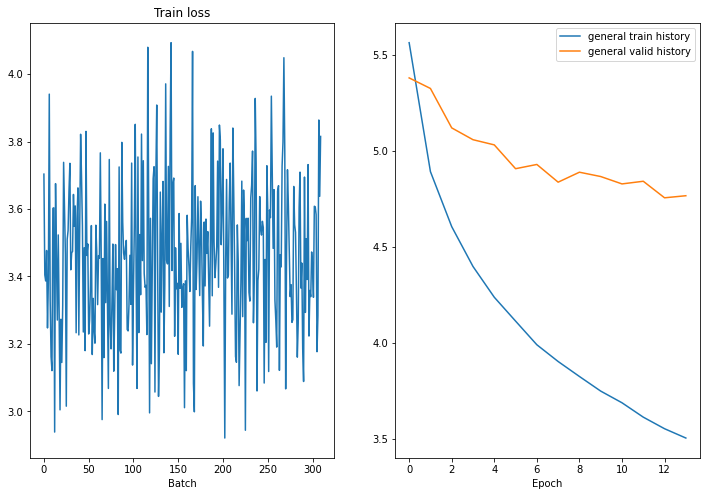

Epoch: 15 | Time: 9m 51s
	Train Loss: 3.456 | Train PPL:  31.705
	 Val. Loss: 4.753 |  Val. PPL: 115.937


In [49]:
print(f'The model with encoder attention has {count_parameters(model_attn):,} trainable parameters')
model_attn.apply(init_weights)
_ = train_process(model_attn)

In [53]:
batch = next(iter(test_iterator))
for idx in [1, 2, 3, 4, 5]:
    src = batch.src[:, idx:idx + 1]
    trg = batch.trg[:, idx:idx + 1]

    print("Using Attention & BPE")
    generate_translation(src, trg, model_attn, TRG.vocab)

original_text__, generated_text__ = translate(model_attn)
print(corpus_bleu([[text] for text in original_text__], generated_text__) * 100)


/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)


Using Attention & BPE
Original: ▁the ▁guest ▁house ▁also ▁offers ▁bike ▁hire .
Generated: ▁the ▁guest ▁house ▁also ▁offers ▁bike ▁hire .

Using Attention & BPE
Original: ▁the ▁property ▁offers ▁free ▁parking .
Generated: ▁the ▁property ▁offers ▁free ▁parking .

Using Attention & BPE
Original: ▁a ▁bathtub ▁is ▁provided ▁in ▁the ▁bathroom .
Generated: ▁the ▁bathroom ▁comes ▁with ▁a ▁bath .

Using Attention & BPE


0it [00:00, ?it/s]

Original: ▁a ▁washing ▁machine ▁can ▁be ▁us ed ▁by ▁all ▁guests ▁in ▁the ▁apartment ▁house .
Generated: ▁a ▁washing ▁machine ▁is ▁available .

Using Attention & BPE
Original: ▁some ▁rooms ▁have ▁a ▁seating ▁area ▁for ▁your ▁convenience .
Generated: ▁some ▁rooms ▁have ▁a ▁seating ▁area .



59it [00:35,  1.64it/s]


19.9901504900573


__Models without BPE__

In [69]:
import imp

import my_network
imp.reload(my_network)
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seqrate

train_history = []
valid_history = []


INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model_attn_0 = Seq2Seq(enc, dec, device).to(device)

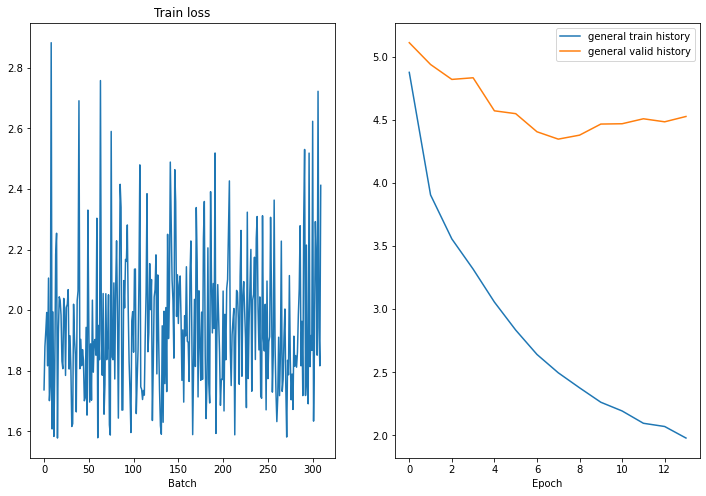

Epoch: 15 | Time: 7m 36s
	Train Loss: 1.952 | Train PPL:   7.040
	 Val. Loss: 4.422 |  Val. PPL:  83.304


In [70]:
print(f'The model with encoder attention has {count_parameters(model_attn_0):,} trainable parameters')
model_attn_0.apply(init_weights)
_ = train_process(model_attn_0)

In [71]:
# del imp
import imp

import my_network
imp.reload(my_network)

Encoder_CNN = my_network.Encoder_CNN
Decoder_CNN = my_network.Decoder_CNN
CNN2Seq = my_network.CNN2Seq

train_history = []
valid_history = []


INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
POS_ENCODING = True
ENC_N_LAYERS = 5
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.5


kernel_size = 5
#to preserve seq len
enc = Encoder_CNN(device, INPUT_DIM, ENC_EMB_DIM, HID_DIM, HID_DIM , POS_ENCODING, kernel_size, kernel_size // 2,
              ENC_N_LAYERS, ENC_DROPOUT)
dec = Decoder_CNN( OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model_cnn = CNN2Seq(enc, dec, device).to(device)

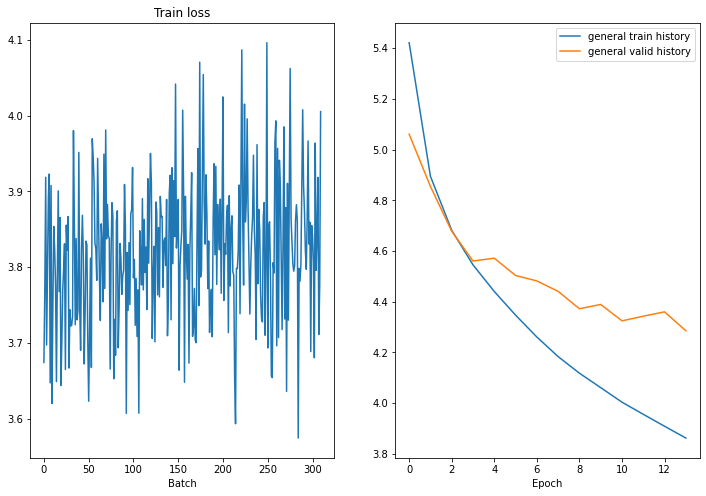

Epoch: 15 | Time: 5m 6s
	Train Loss: 3.820 | Train PPL:  45.618
	 Val. Loss: 4.332 |  Val. PPL:  76.068


In [72]:
print(f'The model with CNN encoder has {count_parameters(model_cnn):,} trainable parameters')
model_cnn.apply(init_weights)
_ = train_process(model_cnn)

In [73]:
import utils
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

__Let's take a look at our network quality__:

In [74]:
batch = next(iter(test_iterator))
for idx in [1, 2, 3, 4, 5]:
    src = batch.src[:, idx:idx + 1]
    trg = batch.trg[:, idx:idx + 1]
    print("Using CNN DECODER")
    generate_translation(src, trg, model_cnn, TRG.vocab)
    print("Using Attention")
    generate_translation(src, trg, model_attn_0, TRG.vocab)


Using CNN DECODER
Original: guests can enjoy the on - site bar .
Generated: the is also a a - and and . . . .

Using Attention
Original: guests can enjoy the on - site bar .
Generated: guests can enjoy the on - site bar .

Using CNN DECODER
Original: each room here will provide you with a tv .
Generated: each room is a tv and tv and and and and . .

Using Attention
Original: each room here will provide you with a tv .
Generated: all rooms are equipped with a tv .

Using CNN DECODER


/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)


Original: free wifi access is available .
Generated: free wifi - fi and free and and and free . . . . . .

Using Attention
Original: free wifi access is available .
Generated: free wi - fi access is available .

Using CNN DECODER
Original: the property offers free parking .
Generated: the property is free parking and site site . . . . .

Using Attention
Original: the property offers free parking .
Generated: free parking .

Using CNN DECODER
Original: all rooms come with air conditioning facilities .
Generated: the air - conditioned conditioning air air conditioning and and and .

Using Attention
Original: all rooms come with air conditioning facilities .
Generated: every room is equipped with air conditioning .



In [75]:
original_text, generated_text = translate(model_attn_0)
print("BLEU for attn model")
print(corpus_bleu([[text] for text in original_text], generated_text) * 100)
print("BLEU for CNN encoder model")
original_text_, generated_text_ = translate(model_cnn)
print(corpus_bleu([[text] for text in original_text_], generated_text_) * 100)


0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)
59it [00:12,  4.79it/s]


BLEU for attn model


1it [00:00,  8.41it/s]

29.789303477381136
BLEU for CNN encoder model


59it [00:10,  5.43it/s]


3.5335910667305535


Baseline solution BLEU score is quite low. Try to achieve at least __24__ BLEU on the test set. 
The checkpoints are:

* __22__ - minimal score to submit the homework, 30% of points

* __27__ - good score, 70% of points

* __29__ - excellent score, 100% of points

__Final remarks__:
* seq2seq models are rather good for NMT;
* lstm models with attention demonstrate rate higer `bleu` than with cnn encoder, maybe because lstm 'feels' contiguous structures better however it trains too slow because of attention mechanisms, attention helped the model to pay attention to different important parts of sentence beacuse we have onedirectional decoder;
* cnn encoder is too weak in my implementation $-$ maybe because of adaptive pooling tha harms the quality but allows to work with sequences of any length, and I am not quite sure about the connection of models, i think it could have be done more elegantly. Maybe, there is a better idea to use it with `lstm`s $-$ it will be smth like self-attention mechanim :)
And maybe it should have been trained more but it took be so much time to debug it, so sorrry( 
* `bpe` allows to have higher score but I had problems with train set, being needed to sample it separately from `torchtext` api but nedd to have fixed length in torch fields to avoid `cuda` memory overflow.

I think that `lr-scheduling` and maybe a sort of decay really help a nmt model to converge faster because our models are prone to overfit due to teacher enforcing and because they have a lot of trainable parameters $-$ regularization is always good thing.
